This notebook shows an example of getting the rat id for each lever / mag event, was mostly just to common sense check that the method for establish rat id was working.

## setup

In [1]:
import sys
sys.path.append('../../')

In [2]:
import pandas as pd
from src.classes.vid_loader import VidLoader
from src.classes.pred_loader import PredLoader
import h5py
import numpy as np
from src.utils.global_utils import ROOTDIR, TESTDIR
from src.utils.global_utils import fps, levx, lev1y, lev2y, mag1y, mag2y, magx, MAXDIST


In [3]:
vids = VidLoader('dyed', out=False)

In [4]:
preds = PredLoader('dyed_preds_df.csv')
good_df = preds.df[(preds.df['correct'] == True) & (preds.df['levers'] == True) & (preds.df['mags'] == True)]

In [5]:
x = good_df.sample()

In [8]:
x

,vid,session,single/multi,test/train,pred,color pair,initial nan,vel nan,correct,final nan,levers,mags,trial type,familiarity,fiber pho
2104,041724_COOPTRAIN_LARGEARENA_EB027Y-EB029R_Camera4,041724,multi,train,True,RY,0.22483,0.236126,True,0.007204,True,True,coop,NaN,False


In [6]:
# session = '041624_KL001_TimeOut/'
# vid = vids.pts_multi_vids['PairedTestingSessions/041624_KL001_TimeOut/Videos'][4][:-4]

# session = '102224_FiberPho_HF003B_HF001R_TimeOut/'
# vid = '102224_Cam2_TrNum4_Coop_HF003B-HF004Y'

# vid = '041624_Cam4_TrNum12_Coop_KL001B-KL001Y'
# session = '041624_KL001_TimeOut/'

# vid = str(x['vid']).split()[1]
# session = str(x['session']).split()[1] + '/'

# vid = '050324_Cam1_TrNum9_Coop_KL002B-KL002Y'
# session = '050324_KL002_TimeOut_Opaque/'

vid, session = '042424_Cam2_TrNum12_Coop_KL005Y-KL005B', '042424_KL005_TimeOut/'

behav = 'Behavioral/processed/' # I think that processed might only be true if in PTS (yikes)
fps = 30

In [7]:
lever = pd.read_csv(ROOTDIR + TESTDIR + session + behav + 'lever/' +  vid + '_lever.csv')
mag = pd.read_csv(ROOTDIR + TESTDIR + session + behav + 'mag/' + vid + '_mag.csv')
# will have to try / catch the hell out of this code!!

In [8]:
vid, session

('042424_Cam2_TrNum12_Coop_KL005Y-KL005B', '042424_KL005_TimeOut/')

In [9]:
with h5py.File(f'{ROOTDIR + TESTDIR + session}Tracking/h5/' + vid + '.predictions.h5','r') as f:
    locations = f["tracks"][:].T

In [10]:
mag.head(20) # look at this !!

,TrialNum,MagNum,AbsTime,Duration,TrialCond,DispTime,TrialTime,Hit,TrialEnd,RatID
0,1,1.0,1.03,0.00,NaN,NaN,NaN,0.0,0.0,NaN
1,1,2.0,6.33,0.00,NaN,NaN,NaN,0.0,0.0,NaN
2,1,1.0,8.62,0.01,NaN,NaN,NaN,0.0,0.0,NaN
3,1,2.0,9.13,0.02,NaN,NaN,NaN,0.0,0.0,0.0
4,1,1.0,13.66,0.00,NaN,NaN,NaN,0.0,0.0,NaN
5,1,2.0,18.77,0.00,NaN,NaN,NaN,0.0,0.0,0.0
6,1,1.0,19.96,0.00,NaN,NaN,NaN,0.0,0.0,NaN
7,1,1.0,22.67,0.00,NaN,NaN,NaN,0.0,0.0,NaN
8,1,1.0,25.81,0.00,NaN,NaN,NaN,0.0,0.0,NaN
9,1,2.0,29.67,0.00,NaN,NaN,NaN,0.0,0.0,0.0


## example

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
nose_locs = locations[:, 0, :, :]
nose_x = locations[:, 0, 0, :]
nose_y = locations[:, 0, 1, :]

x_min, x_max = np.nanmin(nose_x), np.nanmax(nose_x)
y_min, y_max = np.nanmin(nose_y), np.nanmax(nose_y)

In [13]:
x_min, x_max = np.nanmin(nose_x), np.nanmax(nose_x)
y_min, y_max = np.nanmin(nose_y), np.nanmax(nose_y)

In [14]:
# for a given list of events and locations and event type (mag/lever), will add an 
# additional column to events that has the identity of which rat particapted in the 
# event given the rat locations
def get_rat_id(events, locations, event_type):
    ratID = []
    i = []
    bad_frames = []
    # for row in events.itertuples(index=False):
    for index, row in events.iterrows():

        # check if there is an absolute time
        # check if absolute time is within the frame length
        # get both rat distances
            # see if either rat is close enough (check for nan values)
            # if both rats are close enough, check which one is closer

        ratNum = -1
        # is there an absolute time
        if np.isnan(row.AbsTime):
            ratNum = np.nan
            print('no abs time')
        else:
            # calculate frame
            frame = int(round(row.AbsTime * fps, 0))

            # make sure frame is within the range of locations
            if frame > locations.shape[0]:
                ratNum = np.nan
                print('frame out of range')
            else:
                # Get coordinates of both mice for the said frame
                ratpos1 = locations[frame, 0, :, 0]
                ratpos2 = locations[frame, 0, :, 1]
                
                # Calculate the distances
                if event_type == 'lever':
                    if row.LeverNum == 1:
                        distance1 = np.sqrt((ratpos1[0] - levx)**2 + (ratpos1[1] - lev1y)**2)
                        distance2 = np.sqrt((ratpos2[0] - levx)**2 + (ratpos2[1] - lev1y)**2)
                
                    elif row.LeverNum == 2:
                        distance1 = np.sqrt((ratpos1[0] - levx)**2 + (ratpos1[1] - lev2y)**2)
                        distance2 = np.sqrt((ratpos2[0] - levx)**2 + (ratpos2[1] - lev2y)**2)
                    else:
                        ratNum = np.nan #assign number for Nan values
                elif event_type == 'mag':
                    if row.MagNum == 1:
                        distance1 = np.sqrt((ratpos1[0] - magx)**2 + (ratpos1[1] - mag1y)**2)
                        distance2 = np.sqrt((ratpos2[0] - magx)**2 + (ratpos2[1] - mag1y)**2)
            
                    elif row.MagNum == 2:
                        distance1 = np.sqrt((ratpos1[0] - magx)**2 + (ratpos1[1] - mag2y)**2)
                        distance2 = np.sqrt((ratpos2[0] - magx)**2 + (ratpos2[1] - mag2y)**2)
                
                    else:
                        ratNum = np.nan #assign number for Nan values
                else:
                    raise Exception("not a valid event type (yikes)")

                if frame == 438:
                    print(distance1, distance2)
                    print(distance1 < MAXDIST and distance2 < MAXDIST)
                if not np.isnan(ratNum):
                    if distance1 < MAXDIST and distance2 < MAXDIST:
                        ratNum = 0 if distance1 < distance2 else 1
                    elif distance1 < MAXDIST: # dist2 could be nan or non-plausible
                        ratNum = 0
                    elif distance2 < MAXDIST: # dist1 could be nan or non-plausible
                        ratNum = 1
                    else:
                        ratNum = np.nan # neither distance is valid or plausible
                        print(f'neither distance is good for {frame}')
                        bad_frames.append(frame)
        i.append(index)
        # Add new element to the list
        ratID.append(ratNum)
    print(i)
    # Add new column to the dataframe
    events["RatID"] = ratID
    
    return bad_frames # events

13731 [116.59442139 244.22518921] [106.46990967 458.69442749]


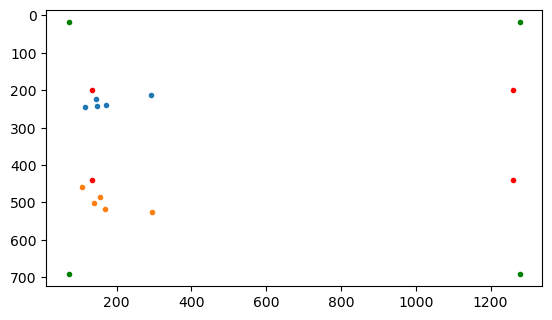

In [21]:
for f in frames:
    if not np.isnan(np.sum(locations[f])):
        # print(f, np.sum(locations[f, 0, :, 0]), np.sum(locations[f, 0, :, 1]))
        print(f, locations[f, 0, :, 0], locations[f, 0, :, 1])
        for i in range(locations.shape[1]):
            plt.plot(locations[f, i, 0, 0], locations[f, i, 1, 0], '.', color='tab:blue')
            
        for i in range(locations.shape[1]):
            plt.plot(locations[f, i, 0, 1], locations[f, i, 1, 1], '.', color='tab:orange')
        
        plt.plot(levx, loc2y, '.', color='r')
        plt.plot(levx, loc1y, '.', color='r')
        plt.plot(magx, loc2y, '.', color='r')
        plt.plot(magx, loc1y, '.', color='r')

        plt.plot(x_min, y_min, '.', color='g')
        plt.plot(x_min, y_max, '.', color='g')
        plt.plot(x_max, y_min, '.', color='g')
        plt.plot(x_max, y_max, '.', color='g')
        plt.gca().set_aspect("equal")
        plt.gca().invert_yaxis()
        plt.show()
        break
    # print(np.sum(locations[frame]))

In [18]:
x_min, x_max, y_min, y_max

(-48.16726182657383, 2098.7778446138564, -21.085930912849832, 586.552001953125)

In [17]:
mag.head(10)

,TrialNum,MagNum,AbsTime,Duration,TrialCond,DispTime,TrialTime,Hit,TrialEnd,RatID
0,1,1.0,1.03,0.00,NaN,NaN,NaN,0.0,0.0,1.0
1,1,2.0,6.33,0.00,NaN,NaN,NaN,0.0,0.0,1.0
2,1,1.0,8.62,0.01,NaN,NaN,NaN,0.0,0.0,1.0
3,1,2.0,9.13,0.02,NaN,NaN,NaN,0.0,0.0,0.0
4,1,1.0,13.66,0.00,NaN,NaN,NaN,0.0,0.0,1.0
5,1,2.0,18.77,0.00,NaN,NaN,NaN,0.0,0.0,1.0
6,1,1.0,19.96,0.00,NaN,NaN,NaN,0.0,0.0,0.0
7,1,1.0,22.67,0.00,NaN,NaN,NaN,0.0,0.0,1.0
8,1,1.0,25.81,0.00,NaN,NaN,NaN,0.0,0.0,1.0
9,1,2.0,29.67,0.00,NaN,NaN,NaN,0.0,0.0,1.0


In [16]:
bad_frames = get_rat_id(mag, locations, 'mag')

no abs time
no abs time
neither distance is good for 13309
neither distance is good for 13867
neither distance is good for 14152
neither distance is good for 14203
neither distance is good for 14973
no abs time
no abs time
no abs time
no abs time
neither distance is good for 18305
no abs time
no abs time
no abs time
neither distance is good for 22328
neither distance is good for 22445
no abs time
no abs time
no abs time
no abs time
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]


In [52]:
int(round(1.85 * 30)), int(round(24.46 * 30))

(56, 734)

56 1058.9972534179688 1456.7451477050781
56 [596.6505127  462.34674072] [1260.38635254  196.35879517]
760.979923413707 43.2225948579803


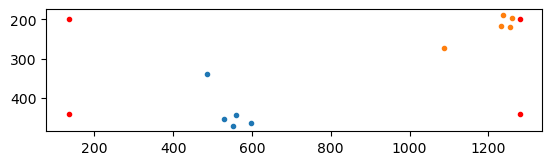

734 1591.2490844726562 1438.9055938720703
734 [1206.69763184  384.55145264] [1250.32458496  188.58100891]
231.12104744274015 60.23620449112969


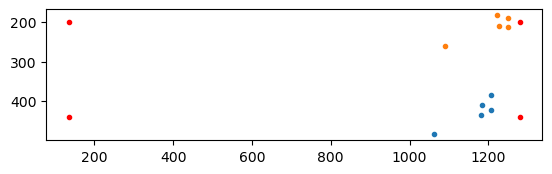

In [53]:
for f in [56, 734]: # bad_frames:
    print(f, np.sum(locations[f, 0, :, 0]), np.sum(locations[f, 0, :, 1]))
    if True: # np.isnan(np.sum(locations[f])):
        # print(f, np.sum(locations[f, 0, :, 0]), np.sum(locations[f, 0, :, 1]))
        print(f, locations[f, 0, :, 0], locations[f, 0, :, 1])
        for i in range(locations.shape[1]):
            plt.plot(locations[f, i, 0, 0], locations[f, i, 1, 0], '.', color='tab:blue')
            
        for i in range(locations.shape[1]):
            plt.plot(locations[f, i, 0, 1], locations[f, i, 1, 1], '.', color='tab:orange')

        ratpos1 = locations[f, 1, :, 0]
        ratpos2 = locations[f, 1, :, 1]
        distance1 = np.sqrt((ratpos1[0] - magx)**2 + (ratpos1[1] - mag1y)**2)
        distance2 = np.sqrt((ratpos2[0] - magx)**2 + (ratpos2[1] - mag1y)**2)
        print(distance1, distance2)
        
        plt.plot(levx, lev1y, '.', color='r')
        plt.plot(levx, lev2y, '.', color='r')
        plt.plot(magx, mag1y, '.', color='r')
        plt.plot(magx, mag2y, '.', color='r')

        # plt.plot(x_min, y_min, '.', color='g')
        # plt.plot(x_min, y_max, '.', color='g')
        # plt.plot(x_max, y_min, '.', color='g')
        # plt.plot(x_max, y_max, '.', color='g')
        plt.gca().set_aspect("equal")
        plt.gca().invert_yaxis()
        plt.show()
    # print(np.sum(locations[frame]))

In [87]:
distance1 < MAXDIST and distance2 < MAXDIST

True

In [31]:
lever.to_csv(ROOTDIR + TESTDIR + session + behav + 'lever/' +  vid + '_lever_II.csv', index=False)
# THIS WILL CREATE A FILE, IF YOU RUN THIS DELETE FILE AFTER PLS!

In [36]:
lever_II = pd.read_csv(ROOTDIR + TESTDIR + session + behav + 'lever/' +  vid + '_lever_II.csv')


In [37]:
lever_II

,TrialNum,LeverNum,AbsTime,TrialCond,DispTime,TrialTime,coopTS,coopSucc,Hit,TrialEnd,AnimalID,RatID
0,1,1,10.92,0,NaN,0.91,NaN,0,1,0,KL001B-KL001Y,1
1,1,1,11.20,0,NaN,1.19,NaN,0,-1,0,KL001B-KL001Y,1
2,1,1,11.73,0,NaN,1.72,NaN,0,-1,0,KL001B-KL001Y,1
3,1,1,12.44,0,NaN,2.43,NaN,0,-1,0,KL001B-KL001Y,1
4,1,1,12.55,0,NaN,2.54,NaN,0,-1,0,KL001B-KL001Y,1
...,...,...,...,...,...,...,...,...,...,...,...,...
131,42,2,491.13,3,492.84,1.02,490.77,1,-2,0,KL001B-KL001Y,1
132,42,1,491.58,3,492.84,1.47,490.77,1,-2,0,KL001B-KL001Y,0
133,43,1,500.66,3,502.83,0.37,500.96,1,1,0,KL001B-KL001Y,1
134,43,2,500.93,3,502.83,0.64,500.96,1,1,1,KL001B-KL001Y,0
